In [4]:
struct Parm
    t::Float64
    V::Float64
    mu::Float64
    T::Float64
    W_MAX::Float64
    K_SIZE::Int
    W_SIZE::Int
end

In [5]:
mutable struct Hamiltonian
    Hk::Array{ComplexF64,2}
    Vx::Array{ComplexF64,2}
    Vy::Array{ComplexF64,2}
    Vxx::Array{ComplexF64,2}
    Vyx::Array{ComplexF64,2}
end

In [6]:
function HandV(k::Array{Float64},p::Parm, Ham::Hamiltonian)
    Ham.Hk = [p.t*(cos(k[1])+cos(k[2])) p.V
    p.V -p.t*(cos(k[1])+cos(k[2]))]

    Ham.Vx = [-p.t*(sin(k[1])) 0.0
    0.0 p.t*(sin(k[1]))]

    Ham.Vy = [-p.t*(sin(k[2])) 0.0
    0.0 p.t*(sin(k[2]))]

    Ham.Vxx = [-p.t*(cos(k[1])) 0.0
    0.0 p.t*(cos(k[1]))]

    Ham.Vyx = [0.0 0.0
    0.0 0.0]
end

HandV (generic function with 1 method)

In [7]:
p = Parm(1.0,0.5,0.0,0.01,0.2,5,10)

Parm(1.0, 0.5, 0.0, 0.01, 0.2, 5, 10)

In [8]:
println(p.T)

0.01


In [9]:
HV = Hamiltonian(zeros(ComplexF64,2,2),zeros(ComplexF64,2,2),zeros(ComplexF64,2,2),zeros(ComplexF64,2,2),zeros(ComplexF64,2,2))

Hamiltonian(Complex{Float64}[0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im], Complex{Float64}[0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im], Complex{Float64}[0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im], Complex{Float64}[0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im], Complex{Float64}[0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im])

In [10]:
println(HV.Hk)

Complex{Float64}[0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im]


In [49]:
kx = collect(Float64,-pi:2*pi/p.K_SIZE:pi)
ky = collect(Float64,-pi:2*pi/p.K_SIZE:pi)

6-element Array{Float64,1}:
 -3.141592653589793
 -1.8849555921538759
 -0.6283185307179586
  0.6283185307179586
  1.8849555921538759
  3.141592653589793

In [50]:
mutable struct Green
    GR::Array{ComplexF64,2}
    GA::Array{ComplexF64,2}
    dGR::Array{ComplexF64,2}
    dGA::Array{ComplexF64,2}
end

In [51]:
function Gk(w::Float64, p::Parm, Ham::Hamiltonian, G::Green)
    GR0 = -HV.Hk + Matrix{Complex{Float64}}(w*I,2,2) + 0.005*Matrix{Complex{Float64}}(1.0im*I,2,2)
    GA0 = GR0'
    G.GR = inv(GR0)
    G.GA = inv(GA0)
    G.dGR = - G.GR * G.GR
    G.dGA = - G.GA * G.GA
end

Gk (generic function with 1 method)

In [1]:
using LinearAlgebra

In [53]:
module transport
    using LinearAlgebra
    export rho_xx

    #=
    function fermiD(w::Float64, T::Float64)
        f = 1.0/(1.0 + exp(w/T))
        return f
    end
    =#

    function dfermiD(w::Float64, T::Float64)
        f = -1.0/(1.0 + exp(w/T))/(1.0 + exp(-w/T))/T
        return f
    end

    function rho_xx(w::Float64, p::Main.Parm, Ham::Main.Hamiltonian, G::Main.Green)
        rx = real(2.0 * p.W_MAX / p.W_SIZE * tr(Ham.Vx * G.GR * Ham.Vx * G.GA) * dfermiD(w, p.T))
        return rx
    end
end

Main.transport

In [54]:
using .transport

In [58]:
total = 0.0
w_sum =  zeros(Float64, p.K_SIZE+1, p.K_SIZE+1)

6×6 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

In [59]:
dk = 2.0*pi/p.K_SIZE

1.2566370614359172

In [60]:
for i = 1:p.K_SIZE+1
    for j = 1:p.K_SIZE+1
        kk = [kx[i],ky[j]]
        HVk = Hamiltonian(zeros(ComplexF64,2,2),zeros(ComplexF64,2,2),zeros(ComplexF64,2,2),zeros(ComplexF64,2,2),zeros(ComplexF64,2,2))
        HandV(kk,p,HVk)
        for ww = 1:p.W_SIZE
            w = 2.0 * (ww-p.W_SIZE/2) * p.W_MAX / p.W_SIZE
            G = Green(zeros(ComplexF64,2,2),zeros(ComplexF64,2,2),zeros(ComplexF64,2,2),zeros(ComplexF64,2,2))
            Gk(w,p,HVk,G)
            w_sum[i,j] += 2.0 * p.W_MAX / p.W_SIZE * transport.rho_xx(w, p, HVk, G) /(2.0*pi)
        end
        total += dk * dk * w_sum[i,j]/(4.0 * pi^2)
    end
end

In [61]:
using PyPlot: PyPlot, plt

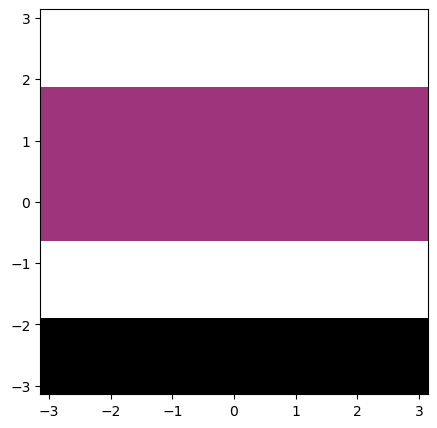

sys:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


PyObject <matplotlib.collections.QuadMesh object at 0x7fc212cc6250>

In [62]:
plt.figure(figsize=(5,5))
plt.pcolormesh(kx,ky,w_sum, cmap="CMRmap")